# 02 linear regression
Below we'll explore linear regression using the `statsmodels` package. We'll also explore the relationship between correlation and R<sup>2</sup>.

## imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
import pandas_datareader.data as web

## data
This will be an illogical example, but we will attempt to regress the price of EA Games based on the price of Activision Blizzard.

In [54]:
start_date = "2014-01-01"
end_date = "2018-01-01"
data_source = "robinhood"

atvi = web.DataReader("ATVI", data_source=data_source, start=start_date, end=end_date)
atvi = atvi.drop(["interpolated", "session"], axis=1)
ea = web.DataReader("EA", data_source=data_source, start=start_date, end=end_date)
ea = ea.drop(["interpolated", "session"], axis=1)

We could reuse the code cited in the link below to reindex the dataframes indices to datetimes, but using "robinhood" as the data_source actually yields datetime indices for `atvi.index.levels[1]` and `ea.index.levels[1]`.

In [22]:
# https://stackoverflow.com/questions/45243291/parse-pandas-multiindex-to-datetime

However, it seems that the tradeoff here is that some of the column types for the features are not numeric by default, but of dtype object.

In [55]:
atvi["high_price"].head()

symbol  begins_at 
ATVI    2017-07-05    57.2548
        2017-07-06    56.7922
        2017-07-07    58.0607
        2017-07-10    58.6178
        2017-07-11    58.2696
Name: high_price, dtype: object

We'll resolve this using the code from the source provided [here](https://stackoverflow.com/questions/36814100/pandas-to-numeric-for-multiple-columns).

In [56]:
cols = atvi.columns
cols

Index(['close_price', 'high_price', 'low_price', 'open_price', 'volume'], dtype='object')

In [57]:
atvi[cols] = atvi[cols].apply(pd.to_numeric, errors="coerce", axis=1)
ea[cols] = ea[cols].apply(pd.to_numeric, errors="coerce", axis=1)

We can visualize the relationship between these two datasets below. Note here, again, that this is purely hypothetical, and that there are hugely more significant factors that influence EA stock than that of ATVI's.

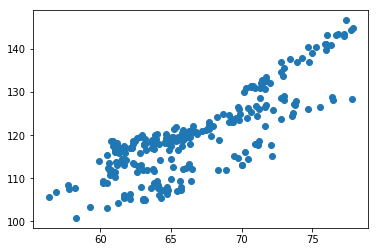

In [58]:
plt.scatter(atvi["close_price"], ea["close_price"])

## correlation
Let's take a look at the correlation between the two datasets, from both a levels and a % change standpoint. An important thing to note here is that for the multindex we have with both dataframes, `dfA.corr(dfB)` always returns nan. Therefore, below we've reindexed copies of the dataframes (only looking at closing prices) using the [resource from before](https://stackoverflow.com/questions/45243291/parse-pandas-multiindex-to-datetime).

In [98]:
atvi_c = pd.DataFrame(atvi["close_price"])
atvi_c.index = pd.to_datetime(atvi_c.index.levels[1])

ea_c = pd.DataFrame(ea["close_price"])
ea_c.index = pd.to_datetime(ea_c.index.levels[1])
atvi_c["close_price"].corr(ea_c["close_price"])

0.82882847010010186

However, we know that when looking at this data, it's more accurate to look at price differentials as opposed to price levels.

In [99]:
atvi_c_delta = atvi_c.pct_change()
ea_c_delta = ea_c.pct_change()
atvi_c_delta["close_price"].corr(ea_c_delta["close_price"])

0.70298872279955149

So, we see that the correlation here is clearly positive and somewhat strong, but not as strong as previously thought when observing only pricing levels.

## linear regression
Now we can attempt to regress EA using ATVI. First, we'll need to drop the NA rows obtained from performing `pct_change()`.

In [103]:
atvi_c_delta = atvi_c_delta.dropna()
ea_c_delta = ea_c_delta.dropna()

In [121]:
regressor = LinearRegression()
regressor.fit(atvi_c_delta, ea_c_delta["close_price"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [132]:
print("r2: {}".format(regressor.score(atvi_c_delta, ea_c_delta["close_price"])))
print("m: {}".format(regressor.coef_))
print("b: {}".format(regressor.intercept_))

r2: 0.4941931443833446
m: [ 0.62135065]
b: 0.00042779785568627937


In [135]:
atvi_c_delta["close_price"][:2]

begins_at
2017-07-06   -0.009447
2017-07-07    0.025963
Name: close_price, dtype: float64

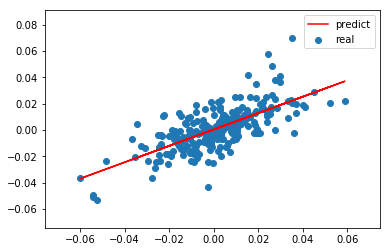

In [139]:
plt.scatter(atvi_c_delta["close_price"], ea_c_delta["close_price"], label="real")
plt.plot(atvi_c_delta["close_price"], regressor.predict(atvi_c_delta), label="predict", color="red")
plt.legend()